## Analyzing Raw Data

In [1]:
## Import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn


Prod_PATH = '/Users/jiujiu/Desktop/caam-495-fluid-flow/New_Data/production' # production data

In [15]:
Prod_unsized = np.loadtxt(Prod_PATH + '/production2.txt')


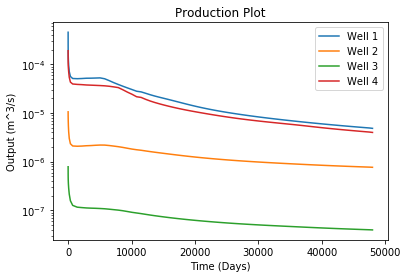

In [16]:
well_1 = plt.plot(Prod_unsized[:,0]/3600.0,Prod_unsized[:,1],label='Well 1')
well_2 = plt.plot(Prod_unsized[:,0]/3600.0,Prod_unsized[:,2],label='Well 2')
well_3 = plt.plot(Prod_unsized[:,0]/3600.0,Prod_unsized[:,3],label='Well 3')
well_4 = plt.plot(Prod_unsized[:,0]/3600.0,Prod_unsized[:,4],label='Well 4')
plt.title('Production Plot')
plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/s)')
plt.legend()

In [ ]:
def preparedata(X_raw,lookback,a,b,shuffle_flag):
    X, Y = create_dataset(X_raw,lookback)
    if lookback == 1:
        X = np.expand_dims(X, axis=1)
        Y = np.expand_dims(Y, axis=1)
    X_scaled,Y_scaled,stds,means = scaledata(X,Y)
    # Y_rescaled = rescaledata(stds,means,Y_scaled)
    random.seed(0)
    indices = list(range(len(X_scaled)))
    if shuffle_flag:
        print('Data shuffled')
        random.shuffle(indices)
    n = len(X)*a//(a+b)
    X_train = X_scaled[indices[:n],:,:]
    y_train = Y_scaled[indices[:n],:]
    X_test = X_scaled[indices[n:],:,:]
    y_test = Y_scaled[indices[n:],:] 
    stds = stds[indices]
    means = means[indices]
    stds_train = stds[:n]
    means_train = means[:n]
    stds_test = stds[n:]
    means_test = means[n:]
    return stds_train,means_train,X_train,y_train,stds_test,means_test,X_test,y_test

## LSTM-RNN

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,X_raw,a,b,shuffle_flag,LSTM_node):
    n = X_raw.shape[1] # size of input
    stds_train,means_train,X_train,y_train,stds_test,means_test,X_test,y_test = preparedata(X_raw,lookback,a,b,shuffle_flag)
    if lookback == 1:
        # change expected output shape if lookback is 1
        y_train = np.squeeze(y_train,axis = 1)
        y_test = np.squeeze(y_test,axis = 1)
    # build neural net
    model = Sequential()
    model.add(LSTM(LSTM_node, input_shape=(lookback, n)))
    model.add(Dense((n)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0, shuffle=False)
    # plot history
    plt.semilogy(np.array(history.history['loss'])/a/10, label='Training Error')
    plt.semilogy(np.array(history.history['val_loss'])/b, label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    model.summary()
    return model,stds_test,means_test,X_test,y_test